In [39]:
import numpy as np
import scipy
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/Han/Desktop/Box Sync/Stat 485/Final Project/cleaned.data.csv', index_col=[0])

<ipython-input-2-30203b14c1a0>:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/Han/Desktop/Box Sync/Stat 485/Final Project/cleaned.data.csv', index_col=[0])


Change loan_approved to 1 or 0 and move it to the last column

In [3]:
label = df['loan_approved']
df = df.drop(['loan_approved'], axis =1)
df.insert(loc=23, column = 'loan_approved', value = label)

In [4]:
df.loan_approved= df.loan_approved.astype(str).map({'No':0, 'Yes':1})

Drop redundant columns, county_name, county_code, denials

In [5]:
df = df.drop(['county_name','county_code','denials'], axis = 1)

Drop column: hoepa_status_name, because it is perfectly in line with the approval of the loan

In [6]:
df = df.drop(['hoepa_status_name'], axis = 1)

Process label encoder on the object variables to work with sk.classifier

In [7]:
df.dtypes

tract_to_msamd_income             float64
population                          int64
minority_population               float64
number_of_owner_occupied_units      int64
number_of_1_to_4_family_units       int64
loan_amount_000s                    int64
hud_median_family_income            int64
applicant_income_000s               int64
property_type_name                 object
owner_occupancy_name               object
loan_type_name                     object
loan_purpose_name                  object
lien_status_name                   object
co_applicant_sex_name              object
census_tract_number               float64
applicant_sex_name                 object
agency_abbr                        object
applicant_race                     object
co_applicant_race                  object
loan_approved                       int64
dtype: object

In [8]:
le = preprocessing.LabelEncoder()
for column_name in df.columns:
    if df[column_name].dtype == object:
        df[column_name] = le.fit_transform(df[column_name])
    else:
        pass

Adjust a few column's dtype

In [9]:
#df.loc[:,'property_type_name':'loan_approved'] = df.loc[:,'property_type_name':'loan_approved'].apply(pd.Categorical)

List the # of copies of each class

In [10]:
df.loan_approved.value_counts()

1    251758
0     60016
Name: loan_approved, dtype: int64

Prepare the Y/label and the X

In [11]:
y = df.loan_approved

In [12]:
x = df.drop('loan_approved', axis =1)

In [13]:
x.dtypes

tract_to_msamd_income             float64
population                          int64
minority_population               float64
number_of_owner_occupied_units      int64
number_of_1_to_4_family_units       int64
loan_amount_000s                    int64
hud_median_family_income            int64
applicant_income_000s               int64
property_type_name                  int32
owner_occupancy_name                int32
loan_type_name                      int32
loan_purpose_name                   int32
lien_status_name                    int32
co_applicant_sex_name               int32
census_tract_number               float64
applicant_sex_name                  int32
agency_abbr                         int32
applicant_race                      int32
co_applicant_race                   int32
dtype: object

In [14]:
x.head()

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,property_type_name,owner_occupancy_name,loan_type_name,loan_purpose_name,lien_status_name,co_applicant_sex_name,census_tract_number,applicant_sex_name,agency_abbr,applicant_race,co_applicant_race
1,121.690002,8381,23.790001,2175,2660,227,73300,116,1,2,0,2,1,2,413.27,0,0,5,5
2,83.370003,4915,23.990000,1268,1777,240,57900,42,1,2,1,1,1,3,9208.01,2,3,4,7
3,91.129997,5075,11.820000,1136,1838,241,73300,117,1,2,0,2,1,0,414.00,2,3,8,9
4,146.169998,5032,8.590000,1525,1820,351,73300,315,1,2,0,2,1,0,405.10,2,4,5,5
5,162.470001,5183,10.500000,1705,2104,417,78100,114,1,2,0,0,1,2,907.00,0,1,8,9


Split

In [15]:
seed = 127
xtrain,xtest, ytrain, ytest = train_test_split(x,y,test_size =.2, 
                                               random_state= seed
                                              )

## Next, we do some un-tuned prediction and use them as the baseline performance. Run a CART with 3-fold CV on the training set to see the accuracy result.

In [99]:
clf = DecisionTreeClassifier(max_depth = None, min_samples_split= 2, random_state=127)
scores = cross_validate(clf, xtrain, ytrain, cv=3, n_jobs=10, scoring=['accuracy','roc_auc'])

In [100]:
print('CART has a base mean accuracy score of %0.4f after 3-fold CV on the training set.' % scores['test_accuracy'].mean())
print('CART has a base mean ROC AUC score of %0.4f after 3-fold CV on the training set.' % scores['test_roc_auc'].mean())

CART has a base mean accuracy score of 0.7375 after 3-fold CV on the training set.
CART has a base mean ROC AUC score of 0.5927 after 3-fold CV on the training set.


## Then we run 3-fold CV on RF on the training set

In [101]:
rfc = RandomForestClassifier(n_estimators= 100, max_depth = None, random_state=127)
scores = cross_validate(rfc, xtrain, ytrain, cv=3, n_jobs=10, scoring=['accuracy','roc_auc'])
print('RF has a base mean accuracy score of %0.4f after 3-fold CV on the training set.' % scores['test_accuracy'].mean())
print('RF has a base mean ROC AUC score of %0.4f after 3-fold CV on the training set.' % scores['test_roc_auc'].mean())

RF has a base mean accuracy score of 0.8179 after 3-fold CV on the training set.
RF has a base mean ROC AUC score of 0.7372 after 3-fold CV on the training set.


## Now, we run 10 repetitions of the untuned models with validation on the test set. 

In [134]:
rfc_accu = []; rfc_auc = [];
clf_accu = []; clf_auc = [];
for i in range(10):
    xtrain1,xtest1, ytrain1, ytest1 = train_test_split(x,y,test_size =.2)
    rfc = RandomForestClassifier(n_jobs = 14).fit(xtrain1,ytrain1)
    rfc_accu.append(rfc.score(xtest1, ytest1))
    rfc_auc.append(roc_auc_score(ytest1, rfc.predict_proba(xtest1)[:,1]))
    clf = DecisionTreeClassifier().fit(xtrain1,ytrain1)
    clf_accu.append(clf.score(xtest1, ytest1))
    clf_auc.append(roc_auc_score(ytest1, clf.predict_proba(xtest1)[:,1]))


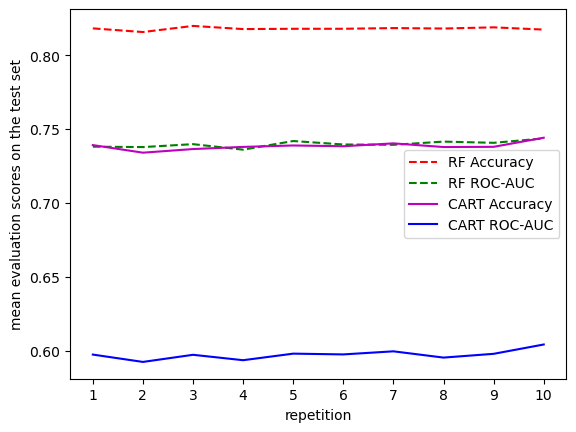

In [116]:
# Plot them   
plt.plot(range(1,11),rfc_accu, 'r--',label = "RF Accuracy")
plt.plot(range(1,11),rfc_auc, 'g--',label = "RF ROC-AUC")
plt.plot(range(1,11),clf_accu, 'm',label = "CART Accuracy")
plt.plot(range(1,11),clf_auc,'b',label = "CART ROC-AUC")
plt.ylabel('mean evaluation scores on the test set')
plt.xlabel('repetition')
plt.xticks(range(1,11))
plt.legend()
plt.show()

### These means can serve as the baseline performances. 

In [114]:
print('Vanilla CART has a base mean test accuracy score of %0.4f from 10 repetitions' % np.mean(clf_accu))
print('Vanilla CART has a base mean test ROC-AUC score of %0.4f from 10 repetitions' % np.mean(clf_auc))
print('Vanilla RF has a base mean test accuracy score of %0.4f from 10 repetitions' % np.mean(rfc_accu))
print('Vanilla RF has a base mean test ROC-AUC score of %0.4f from 10 repetitions' % np.mean(rfc_auc))

Vanilla CART has a base mean test accuracy score of 0.7385 from 10 repetitions
Vanilla CART has a base mean test ROC-AUC score of 0.5974 from 10 repetitions
Vanilla RF has a base mean test accuracy score of 0.8180 from 10 repetitions
Vanilla RF has a base mean test ROC-AUC score of 0.7399 from 10 repetitions


## Next, let's tune the model, i.e. hyperparamters. 

### The hyper parameters that need to be tuned are: n_estimators(# of trees), min_samples_split (min # of samples required to split an internal node), min_samples_leaf(min # of samples required to be at a leaf node), max_depth, max_samples (proportion of the training samples given to each tree, max = 1, this will speed up if we can lower it),  max_features (max of features given to each tree, default is square.root of d. Conventialy , the ideal number is just around the default), criterion ('gini' or 'entropy'), class_weight (None or 'balanced')

### The importance of hyperparameters of RF comes in: n_estimators> max_depth> min_samples_split = min_samples_leaf > max_features. others are data dependent. 

Let's try to plot the learning curve of n_estimators

2200 0.740404667513671 5.682381762780277e-08
700 0.739978268015235 4.683405248597531e-08
2200 0.740404667513671 5.682381762780277e-08 0.06738979347250534


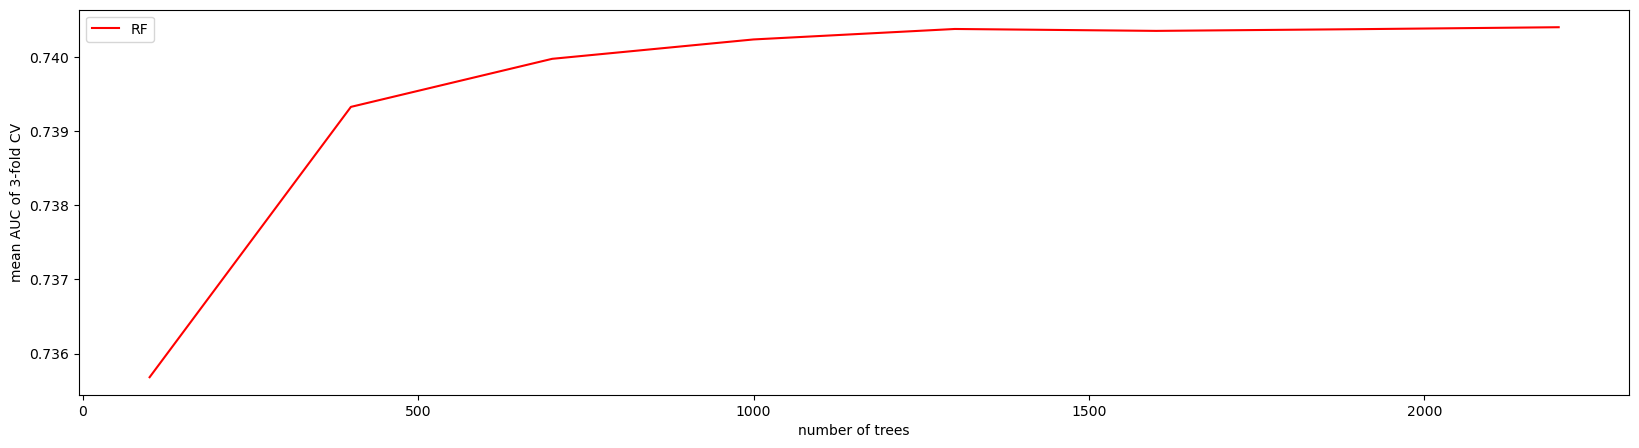

In [43]:
axisx = range(100,2201,300)
rs = []
var = []
ge = []
for i in axisx:
    rfc = RandomForestClassifier(n_estimators=i,n_jobs=14, random_state = 38)
    cvresult = cross_val_score(rfc, xtrain, ytrain, cv=3, n_jobs=14, scoring='roc_auc')
    #记录1-偏差
    rs.append(cvresult.mean())
    #记录方差
    var.append(cvresult.var())
    #计算泛化误差的可控部分
    ge.append((1 - cvresult.mean())**2+cvresult.var())
#打印AUC最高所对应的参数取值，并打印这个参数下的方差
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
#打印方差最低时对应的参数取值，并打印这个参数下的AUC
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))

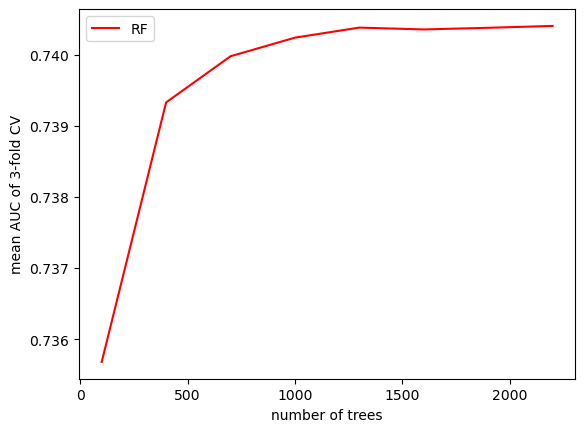

In [53]:
plt.plot(axisx,rs,c="red",label="RF")
plt.ylabel('mean AUC of 3-fold CV')
plt.xlabel('number of trees')
plt.legend()
plt.show()

In [52]:
np.add(rs, var)

array([0.73568123, 0.73932966, 0.73997831, 0.7402398 , 0.74038105,
       0.74035532, 0.74037828, 0.74040472])

It seems like the performance boost by incraesing n_estimators is saturated after 1,300. We'd like to keep this number low to save computation power. Now, we will fine tune the n_estimators via grid serach based on the above optimal value 1,300. 

In [16]:
n_estimator_grid = {'n_estimators':np.arange(1200, 1401, 25)}

rfc = RandomForestClassifier(n_jobs=1, random_state = 38)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = n_estimator_grid, 
                          cv = 3, n_jobs = 14, verbose = 2, return_train_score=False)

In [17]:
# Fit the grid search to the data
grid_search.fit(xtrain, ytrain);

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [18]:
grid_search.best_params_

{'n_estimators': 1375}

Instead of doing grid search on all hyperparas together, we'd tune the next important hyperpara first via learning curve frist, then gridsearchCV

15 0.7622305663494716 6.0399649959688735e-06


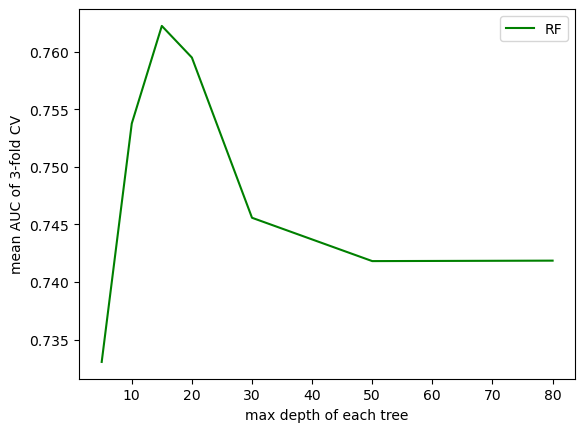

In [24]:
axisx = [5, 10, 15, 20, 30, 50, 80, None]
rs = []
var = []

for i in axisx:
    rfc = RandomForestClassifier(n_estimators=1375, max_depth = i,n_jobs=14, random_state = 38)
    cvresult = cross_val_score(rfc, xtrain, ytrain, cv=3, n_jobs=14, scoring='roc_auc')
    #记录1-偏差
    rs.append(cvresult.mean())
    #记录方差
    var.append(cvresult.var())
#打印AUC最高所对应的参数取值，并打印这个参数下的方差
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
#打印方差最低时对应的参数取值，并打印这个参数下的R2
plt.plot(axisx,rs,c="green",label="RF")
plt.ylabel('mean AUC of 3-fold CV')
plt.xlabel('max depth of each tree')
plt.legend()
plt.show()

It seems like the AUC performance is peaked when the max_depth around 15. We'd like to keep this number in the middle to keep the generalization error to its smallest. Now, we will move onto the less important hyper-parameters using grid search.

In [92]:
# Create the parameter grid based on the results of learning curves plot above
tree_split_param_grid = {
    'min_samples_leaf': [1,2,4 ],
    'min_samples_split': [5, 10, 15,100],
}


In [93]:
rfc = RandomForestClassifier(n_estimators = 1375, max_depth=15, warm_start=True,
                            n_jobs=1, random_state = 16)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = tree_split_param_grid, 
                          cv = 3, n_jobs = 14, verbose = 2, scoring = 'roc_auc')
# Fit the grid search to the data
grid_search.fit(xtrain, ytrain);

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [94]:
best_grid = grid_search.best_estimator_
grid_roc_auc = roc_auc_score(ytest, best_grid.predict_proba(xtest)[:,1])

In [97]:
grid_roc_auc

0.7614000539336078

In [95]:
grid_accuracy = best_grid.score(xtest, ytest)
grid_accuracy

0.8229813166546388

In [98]:
 grid_search.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=15,
                       n_estimators=1375, n_jobs=1, random_state=16,
                       warm_start=True)

Next, we continue to tune other minor hyperparameters using another round of GridSearch

In [117]:
# Create the parameter grid based on the results of learning curves plot above
minor_param_grid = {
    'ccp_alpha': [0.0, 0.1, 0.2],
    'max_samples': [0.6, 0.7, 0.8]
}

rfc = RandomForestClassifier(n_estimators = 1375, max_depth=15, warm_start=True,
                             min_samples_leaf = 2, min_samples_split =15, 
                             n_jobs=1, random_state = 16)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = minor_param_grid, 
                           cv = 3, n_jobs = 14, verbose = 2, scoring = 'roc_auc')
# Fit the grid search to the data
grid_search.fit(xtrain, ytrain);

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [118]:
best_grid = grid_search.best_estimator_
grid_roc_auc = roc_auc_score(ytest, best_grid.predict_proba(xtest)[:,1])
grid_roc_auc

0.7614379702859772

In [119]:
grid_accuracy = best_grid.score(xtest, ytest)
grid_accuracy

0.8226605725282655

#### Do grid search on a few other very minor hyperparameters

In [126]:
# change criterion to 'entorpy' and see
rfc = RandomForestClassifier(max_depth=15, max_samples=0.9, min_samples_leaf=2,
                       min_samples_split=15, n_estimators=1375, n_jobs=10,
                       criterion = 'entropy',
                       random_state=16, warm_start=True)
rfc_model = rfc.fit(xtrain, ytrain)
roc_auc_score(ytest, rfc_model.predict_proba(xtest)[:,1])

0.7621400913644448

#### Wow, change criterion to 'entropy' increases the AUC by 0.0007

In [127]:
# change max_features to 'sqrt' and see
rfc = RandomForestClassifier(max_depth=15, max_samples=0.9, min_samples_leaf=2,
                       min_samples_split=15, n_estimators=1375, n_jobs=10, 
                       criterion = 'entropy',
                       max_features = 'sqrt',
                       random_state=16, warm_start=True)
rfc_model = rfc.fit(xtrain, ytrain)
roc_auc_score(ytest, rfc_model.predict_proba(xtest)[:,1])

0.7621400913644448

change the max_features from "auto" to "sqrt" is useless. 

### By this point, we can save our hyperparameter tuned model

In [128]:
best_rfc = rfc
best_rfc

RandomForestClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       max_samples=0.9, min_samples_leaf=2,
                       min_samples_split=15, n_estimators=1375, n_jobs=10,
                       random_state=16, warm_start=True)

### also get the tuned model's accuracy

In [135]:
best_accuracy = best_rfc.score(xtest, ytest)
best_accuracy

0.8228369817977709

### also get the tuned model's ROC-AUC

In [136]:
best_roc_auc = roc_auc_score(ytest, rfc_model.predict_proba(xtest)[:,1])
best_roc_auc

0.7621400913644448

## Interpretate the Best Model from Grid Search

### Feature Importance

Feature Ranking
 1) applicant_income_000s          0.182569
 2) loan_purpose_name              0.175631
 3) loan_amount_000s               0.116898
 4) agency_abbr                    0.066962
 5) census_tract_number            0.053218
 6) minority_population            0.052761
 7) tract_to_msamd_income          0.051049
 8) population                     0.043537
 9) number_of_1_to_4_family_units  0.043336
10) number_of_owner_occupied_units 0.042656
11) hud_median_family_income       0.029198
12) loan_type_name                 0.026058
13) co_applicant_race              0.025426
14) co_applicant_sex_name          0.023866
15) applicant_race                 0.023241
16) lien_status_name               0.014741
17) applicant_sex_name             0.011656
18) property_type_name             0.009591
19) owner_occupancy_name           0.007606


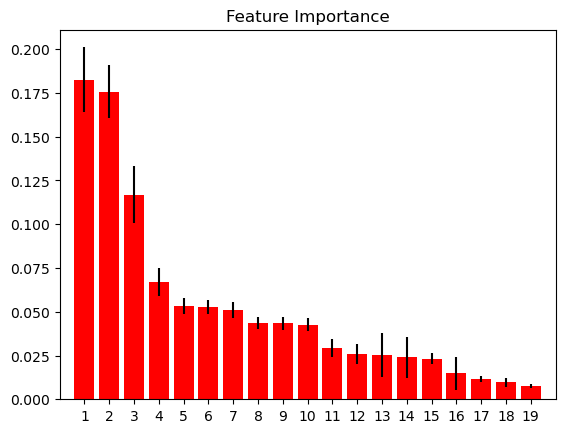

In [132]:
importances = best_rfc.feature_importances_ # feature's import
std = np.std([tree.feature_importances_ for tree in best_rfc.estimators_], axis = 0)
indices = np.argsort(importances)[::-1] # Print out the feature importance ranking, -1 is to indicator ascending
print("Feature Ranking")
for f in range(xtrain.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, xtrain.columns[indices[f]], importances[indices[f]]))
plt.figure()
plt.title("Feature Importance")
plt.bar(range(xtrain.shape[1]), importances[indices], color = 'r', yerr = std[indices], align = 'center')
plt.xticks(range(xtrain.shape[1]), range(1,xtrain.shape[1]+1))
plt.xlim([-1, xtrain.shape[1]])
plt.show()

ROC curve

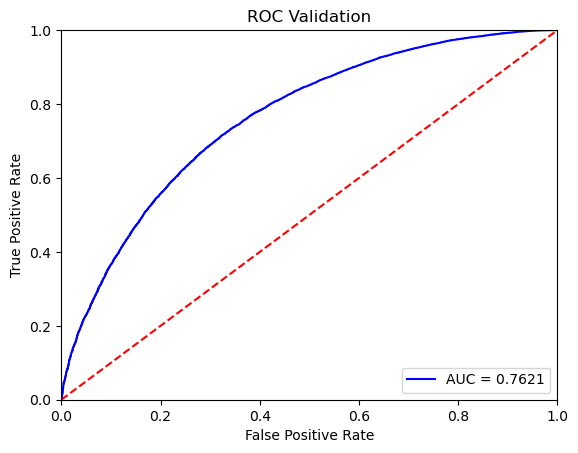

In [133]:
predictions_validation = best_rfc.predict_proba(xtest)[:,1]
fpr, tpr, _ = roc_curve(ytest, predictions_validation)
roc_auc = auc(fpr, tpr)
plt.title('ROC Validation')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusion: 

In [138]:
print('The Random Forest classifier has an accuracy of %.4f, and a ROC-AUC of %.4f' % (best_accuracy, best_roc_auc))

The Random Forest classifier has an accuracy of 0.8228, and a ROC-AUC of 0.7621


In [145]:
print("Compared to the vanilla model's accuracy of %.4f, the tuning process increaes its performance by %.4f to %.4f." 
      %(0.8180, best_accuracy - 0.8180, best_accuracy))

Compared to the vanilla model's accuracy of 0.8180, the tuning process increaes its performance by 0.0048 to 0.8228.


In [146]:
print("Compared to the vanilla model's ROC-AUC score of %.4f, the tuning process increaes its performance by %.4f to %.4f." 
      %(0.7399, best_roc_auc - 0.7399, best_roc_auc))

Compared to the vanilla model's ROC-AUC score of 0.7399, the tuning process increaes its performance by 0.0222 to 0.7621.
